# **Programa Principal**

In [1]:
#!pip install pandas -q
#!pip install matplotlib -q
#!pip install seaborn -q
#!pip install db-sqlite3 -q
#!pip install SQLAlchemy -q
#!pip install requests -q
#!pip install jsonlib -q
#!pip install folium


## 1) Bibliotecas

In [12]:
import pandas as pd
import numpy as np
import folium
import json

## 2) Extração de dados

In [50]:
df_janeiro = pd.read_csv('./dados/focos_mensal_br_202401.csv')
df_fevereiro = pd.read_csv('./dados/focos_mensal_br_202402.csv')
df_marco = pd.read_csv('./dados/focos_mensal_br_202403.csv')
df_abril = pd.read_csv('./dados/focos_mensal_br_202404.csv')
df_maio = pd.read_csv('./dados/focos_mensal_br_202405.csv')
df_junho = pd.read_csv('./dados/focos_mensal_br_202406.csv')

In [14]:
#setando o caminho + arquivos que serão concatenados
path = 'dados/focos_mensal_br_2024'

#concatenar os arquivos csv com o nome igual ao setado em "path"
df_brasil_2024 = pd.concat([pd.read_csv(f"{path}{mes:02}.csv") for mes in range(1,7)])

#exibir a tabela concatenada
df_brasil_2024

,id,lat,lon,data_hora_gmt,satelite,municipio,estado,pais,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp
0,966ed445-fa70-3369-9802-3e74c5765684,-12.5667,-41.4364,2024-01-01 00:06:16,GOES-16,LENÇÓIS,BAHIA,Brasil,2919306,29,33,8,1.38,0.70,Caatinga,76.5
1,0669c14d-7a39-3d98-9f20-23e118fbcf09,-12.5662,-41.4611,2024-01-01 00:06:16,GOES-16,LENÇÓIS,BAHIA,Brasil,2919306,29,33,9,1.73,0.83,Caatinga,81.4
2,53a46800-fa40-3323-9b20-05108d435c24,-18.0629,-57.3721,2024-01-01 00:06:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,14.42,0.00,Pantanal,59.8
3,d0af560b-c440-3554-a5c6-83fb055304e8,-18.0823,-57.3902,2024-01-01 00:06:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,12.93,-999.00,Pantanal,63.4
4,b509b339-729d-3a30-a7d9-8a6a33398a4f,-18.0823,-57.3902,2024-01-01 00:16:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,12.93,-999.00,Pantanal,64.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353038,feb4f53b-e202-350c-8f74-7f82fc40cb1d,-19.6805,-57.0351,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,62,0.00,0.84,Pantanal,106.4
353039,7fcb2a72-dd94-33e5-b249-69de261a3faf,-19.6801,-57.0561,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,60,0.00,0.94,Pantanal,60.7
353040,7d66733d-24fd-3205-967d-17dc67e60fd2,-20.0190,-42.8786,2024-06-30 23:36:57,GOES-16,SÃO DOMINGOS DO PRATA,MINAS GERAIS,Brasil,3161007,31,33,88,0.00,1.00,Mata Atlântica,86.7
353041,defe4e3a-b07b-30a1-9a9c-9e3403ab2967,-19.6604,-57.0379,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,60,0.00,0.89,Pantanal,68.3


In [15]:
#mostrar quantidade de celulas x colunas
df_brasil_2024.shape

(983232, 16)

In [16]:
#descrever 
df_brasil_2024.describe()

,lat,lon,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,frp
count,983232.000000,983232.000000,9.832320e+05,983232.000000,983232.0,983232.000000,983232.000000,983232.000000,951407.000000
mean,-9.993129,-53.809391,3.189780e+06,31.827838,33.0,9.495614,0.690434,-21.650540,33.780956
std,8.596091,6.936608,1.611532e+06,16.108001,0.0,104.052397,3.708917,147.580664,57.590815
min,-33.715350,-73.666210,1.100015e+06,11.000000,33.0,-999.000000,0.000000,-999.000000,0.000000
25%,-17.497535,-60.026930,1.400472e+06,14.000000,33.0,5.000000,0.000000,0.210000,3.800000
50%,-11.185035,-56.279550,2.922250e+06,29.000000,33.0,14.000000,0.000000,0.770000,9.400000
75%,-2.304890,-48.093350,5.006903e+06,50.000000,33.0,29.000000,0.000000,1.000000,54.200000
max,5.163930,-34.809400,5.300108e+06,53.000000,33.0,93.000000,252.980000,1.000000,4720.700000


### 2.1. Queimadas 2023

`Tratamento dos nomes das Colunas`

In [17]:
#exibir nome das colunas
df_brasil_2024.columns

Index(['id', 'lat', 'lon', 'data_hora_gmt', 'satelite', 'municipio', 'estado',
       'pais', 'municipio_id', 'estado_id', 'pais_id', 'numero_dias_sem_chuva',
       'precipitacao', 'risco_fogo', 'bioma', 'frp'],
      dtype='object')

In [18]:
#renomear colunas
df_brasil_2024.rename(columns={'lat': 'latitude', 'lon': 'longitude'}, inplace=True)

`Tratamento de Null`

In [19]:
#verificando quais colunas possuem valores nulos
df_brasil_2024.isnull().sum()

id                           0
latitude                     0
longitude                    0
data_hora_gmt                0
satelite                     0
municipio                    0
estado                       0
pais                         0
municipio_id                 0
estado_id                    0
pais_id                      0
numero_dias_sem_chuva        0
precipitacao                 0
risco_fogo                   0
bioma                        1
frp                      31825
dtype: int64

In [20]:
df_brasil_2024.fillna('Desconhecido')

,id,latitude,longitude,data_hora_gmt,satelite,municipio,estado,pais,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp
0,966ed445-fa70-3369-9802-3e74c5765684,-12.5667,-41.4364,2024-01-01 00:06:16,GOES-16,LENÇÓIS,BAHIA,Brasil,2919306,29,33,8,1.38,0.70,Caatinga,76.5
1,0669c14d-7a39-3d98-9f20-23e118fbcf09,-12.5662,-41.4611,2024-01-01 00:06:16,GOES-16,LENÇÓIS,BAHIA,Brasil,2919306,29,33,9,1.73,0.83,Caatinga,81.4
2,53a46800-fa40-3323-9b20-05108d435c24,-18.0629,-57.3721,2024-01-01 00:06:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,14.42,0.00,Pantanal,59.8
3,d0af560b-c440-3554-a5c6-83fb055304e8,-18.0823,-57.3902,2024-01-01 00:06:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,12.93,-999.00,Pantanal,63.4
4,b509b339-729d-3a30-a7d9-8a6a33398a4f,-18.0823,-57.3902,2024-01-01 00:16:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,12.93,-999.00,Pantanal,64.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353038,feb4f53b-e202-350c-8f74-7f82fc40cb1d,-19.6805,-57.0351,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,62,0.00,0.84,Pantanal,106.4
353039,7fcb2a72-dd94-33e5-b249-69de261a3faf,-19.6801,-57.0561,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,60,0.00,0.94,Pantanal,60.7
353040,7d66733d-24fd-3205-967d-17dc67e60fd2,-20.0190,-42.8786,2024-06-30 23:36:57,GOES-16,SÃO DOMINGOS DO PRATA,MINAS GERAIS,Brasil,3161007,31,33,88,0.00,1.00,Mata Atlântica,86.7
353041,defe4e3a-b07b-30a1-9a9c-9e3403ab2967,-19.6604,-57.0379,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,60,0.00,0.89,Pantanal,68.3


In [21]:
#remover espaços em branco dos nomes das colunas

df_brasil_2024.columns = df_brasil_2024.columns.str.strip()

#remover espaços em branco dos dados das células

df_brasil_2024 = df_brasil_2024.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df_brasil_2024

,id,latitude,longitude,data_hora_gmt,satelite,municipio,estado,pais,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp
0,966ed445-fa70-3369-9802-3e74c5765684,-12.5667,-41.4364,2024-01-01 00:06:16,GOES-16,LENÇÓIS,BAHIA,Brasil,2919306,29,33,8,1.38,0.70,Caatinga,76.5
1,0669c14d-7a39-3d98-9f20-23e118fbcf09,-12.5662,-41.4611,2024-01-01 00:06:16,GOES-16,LENÇÓIS,BAHIA,Brasil,2919306,29,33,9,1.73,0.83,Caatinga,81.4
2,53a46800-fa40-3323-9b20-05108d435c24,-18.0629,-57.3721,2024-01-01 00:06:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,14.42,0.00,Pantanal,59.8
3,d0af560b-c440-3554-a5c6-83fb055304e8,-18.0823,-57.3902,2024-01-01 00:06:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,12.93,-999.00,Pantanal,63.4
4,b509b339-729d-3a30-a7d9-8a6a33398a4f,-18.0823,-57.3902,2024-01-01 00:16:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,12.93,-999.00,Pantanal,64.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353038,feb4f53b-e202-350c-8f74-7f82fc40cb1d,-19.6805,-57.0351,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,62,0.00,0.84,Pantanal,106.4
353039,7fcb2a72-dd94-33e5-b249-69de261a3faf,-19.6801,-57.0561,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,60,0.00,0.94,Pantanal,60.7
353040,7d66733d-24fd-3205-967d-17dc67e60fd2,-20.0190,-42.8786,2024-06-30 23:36:57,GOES-16,SÃO DOMINGOS DO PRATA,MINAS GERAIS,Brasil,3161007,31,33,88,0.00,1.00,Mata Atlântica,86.7
353041,defe4e3a-b07b-30a1-9a9c-9e3403ab2967,-19.6604,-57.0379,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,60,0.00,0.89,Pantanal,68.3


`Exclusão de colunas não utilizadas`

In [22]:
#removendo colunas
df_brasil_2024.drop('frp', axis=1, inplace=True)
df_brasil_2024.drop('id', axis=1, inplace=True)
df_brasil_2024.drop('pais', axis=1, inplace=True)
df_brasil_2024.drop('municipio_id', axis=1, inplace=True)
df_brasil_2024.drop('estado_id', axis=1, inplace=True)
df_brasil_2024.drop('pais_id', axis=1, inplace=True)

`Exclusão de Dados incoerentes`

"Nos downloads de focos do BDQ-Banco de Dados de Queimadas, o atributo "RiscoFogo" dos focos é o valor do Risco de Fogo previsto para o mesmo dia da ocorrência do foco, segundo o método de cálculo descrito em: Método do Cálculo do Risco de Fogo do Programa do INPE. Neste documento você vai notar que os valores são válidos de 0 a 1 e, o número -999 representa valor inválido, normalmente relacionado como área urbana ou corpos d'água, onde não faz sentido calcular o Riso de Fogo."
Disponível em: <https://terrabrasilis.dpi.inpe.br/queimadas/portal/faq/index.html> Pergunta 43

In [51]:
df_brasil_2024.query('risco_fogo != -999', inplace=True)
#df_brasil_2024

## 3) Gráficos

### 3.1. Mapa de calor (Heatmap) de Risco de Fogo

In [52]:
#Diogo
Risk_of_Fire=df_brasil_2024.sort_values(by='risco_fogo',ascending=False)
new_set = Risk_of_Fire.head(25)

In [53]:
#Trasforma valores do dataframe para lista
coordenadas_fogo = new_set[['latitude', 'longitude']].values.tolist()
municipios = new_set[['municipio']].values.tolist()
print(coordenadas_fogo[0:4])
print(municipios[0:4])

[[-11.2401, -44.4728], [-11.9124, -45.4149], [-10.7614, -49.5223], [-18.4195, -49.6013]]
[['SANTA RITA DE CÁSSIA'], ['BARREIRAS'], ['LAGOA DA CONFUSÃO'], ['ITUMBIARA']]


In [54]:
#Utilziando o folium

#Definição de ponto central
F_Mapa = folium.Map([-15.797515,-47.891887],zoom_start=5,control_scale=True)

#Plotagem de marcadores no mapa
for i in range(len(coordenadas_fogo)):
    pontos = coordenadas_fogo[i]
    cid = municipios[i]
    folium.Marker(pontos, popup=cid).add_to(F_Mapa)
F_Mapa



### 3.2. Mapa de precipitação

In [81]:
#Diogo
precipita ',ascending=False)
p_new_set = precipitation_set.head(25)

In [56]:
#Trasforma valores do dataframe para lista
coordenadas_agua = p_new_set[['latitude', 'longitude']].values.tolist()
municipios = p_new_set[['municipio']].values.tolist()
chuva = p_new_set[['precipitacao']].values.tolist()
print(coordenadas_agua[0:4])
print(municipios[0:4])
print(chuva[0:4])

[[-29.50417, -52.48787], [-28.55103, -55.36242], [0.3826, -60.5695], [0.3806, -60.578098]]
[['SINIMBU'], ['SANTO ANTÔNIO DAS MISSÕES'], ['RORAINÓPOLIS'], ['RORAINÓPOLIS']]
[[252.98], [230.9], [157.24], [156.32]]


In [57]:
#Definição de ponto central
P_Mapa = folium.Map([-15.797515,-47.891887],zoom_start=5,control_scale=True)

#Plotagem de marcadores no mapa
for i in range(len(coordenadas_agua)):
    pontos = coordenadas_agua[i]
    cid = municipios[i]
    agua = chuva[i]
    folium.Marker(pontos, popup=(cid,agua)).add_to(P_Mapa)
P_Mapa

### 3.3. Gráfico de Linha para Número de Dias sem Chuva

In [58]:
#Alex

### 3.4. Gráfico de Dispersão (Scatter Plot)

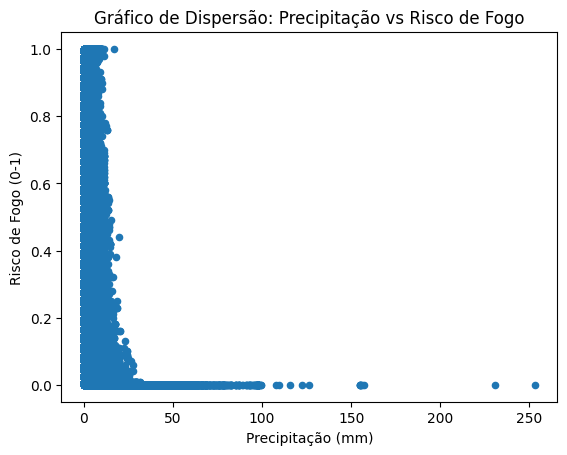

In [59]:
df_brasil_2024.plot(
    kind='scatter', 
    x='precipitacao', 
    y='risco_fogo',
    ylabel='Risco de Fogo (0-1)', 
    xlabel='Precipitação (mm)', 
    title='Gráfico de Dispersão: Precipitação vs Risco de Fogo');

**Explicação**: 
- A precipitação é um fator que influencia significativamente a redução do risco de fogo;
- Quanto maior o nível de precipitação, menor é o risco de fogo e vice-versa;
- Portanto, há uma correlação inversa entre o Risco de fogo e a precipitação

### 3.5. Análise Temporal

In [60]:
# Thiago

### 3.6. Gráfico de Barras por Série Temporal Precipitação por Regiao:

In [61]:
# DataFrame que separa os estados em regiões
def mapear_regioes(df):
    # Dicionário para mapeamento de estados por região
    regioes = {
        'Norte': ['ACRE', 'AMAPÁ', 'AMAZONAS', 'PARÁ', 'RONDÔNIA', 'RORAIMA', 'TOCANTINS'],
        'Nordeste': ['ALAGOAS', 'BAHIA', 'CEARÁ', 'MARANHÃO', 'PARAÍBA', 'PERNAMBUCO', 'PIAUÍ', 'RIO GRANDE DO NORTE', 'SERGIPE'],
        'Centro-Oeste': ['GOIÁS', 'MATO GROSSO', 'MATO GROSSO DO SUL', 'DISTRITO FEDERAL'],
        'Sudeste': ['ESPÍRITO SANTO', 'MINAS GERAIS', 'RIO DE JANEIRO', 'SÃO PAULO'],
        'Sul': ['PARANÁ', 'RIO GRANDE DO SUL', 'SANTA CATARINA']
    }

    # Criar uma nova coluna 'regiao' baseada no estado
    df['regiao'] = df['estado'].map(lambda estado: next((regiao for regiao, estados in regioes.items() if estado in estados), 'Desconhecida'))
    
    # Imprimir as regiões e seus estados mapeados
    for regiao, estados in regioes.items():
        print(f'Região: {regiao}')
        print(f'Estados: {", ".join(estados)}\n')
    
    return df

# Aplicar ao DataFrame principal
df_brasil_2024 = mapear_regioes(df_brasil_2024)

# Imprimir as regiões únicas
print(df_brasil_2024['regiao'].unique())

Região: Norte
Estados: ACRE, AMAPÁ, AMAZONAS, PARÁ, RONDÔNIA, RORAIMA, TOCANTINS

Região: Nordeste
Estados: ALAGOAS, BAHIA, CEARÁ, MARANHÃO, PARAÍBA, PERNAMBUCO, PIAUÍ, RIO GRANDE DO NORTE, SERGIPE

Região: Centro-Oeste
Estados: GOIÁS, MATO GROSSO, MATO GROSSO DO SUL, DISTRITO FEDERAL

Região: Sudeste
Estados: ESPÍRITO SANTO, MINAS GERAIS, RIO DE JANEIRO, SÃO PAULO

Região: Sul
Estados: PARANÁ, RIO GRANDE DO SUL, SANTA CATARINA

['Nordeste' 'Centro-Oeste' 'Norte' 'Sudeste' 'Sul']


[1 2 3 4 5 6]
mes                  1          2         3         4        5        6
regiao                                                                 
Centro-Oeste  73489.54  111299.01  53263.86  23880.80  5865.73  1408.88
Nordeste      63839.84   35973.98  35814.73  11766.12  3407.91  1594.68
Norte         41297.50   31471.84  55664.95  23781.96  7107.76  5895.33
Sudeste       12162.59   13783.35  10324.33   1331.81  1198.04   247.78
Sul            4752.18    6728.36   2159.11   2079.13  1094.65   428.48


<Figure size 1500x800 with 0 Axes>

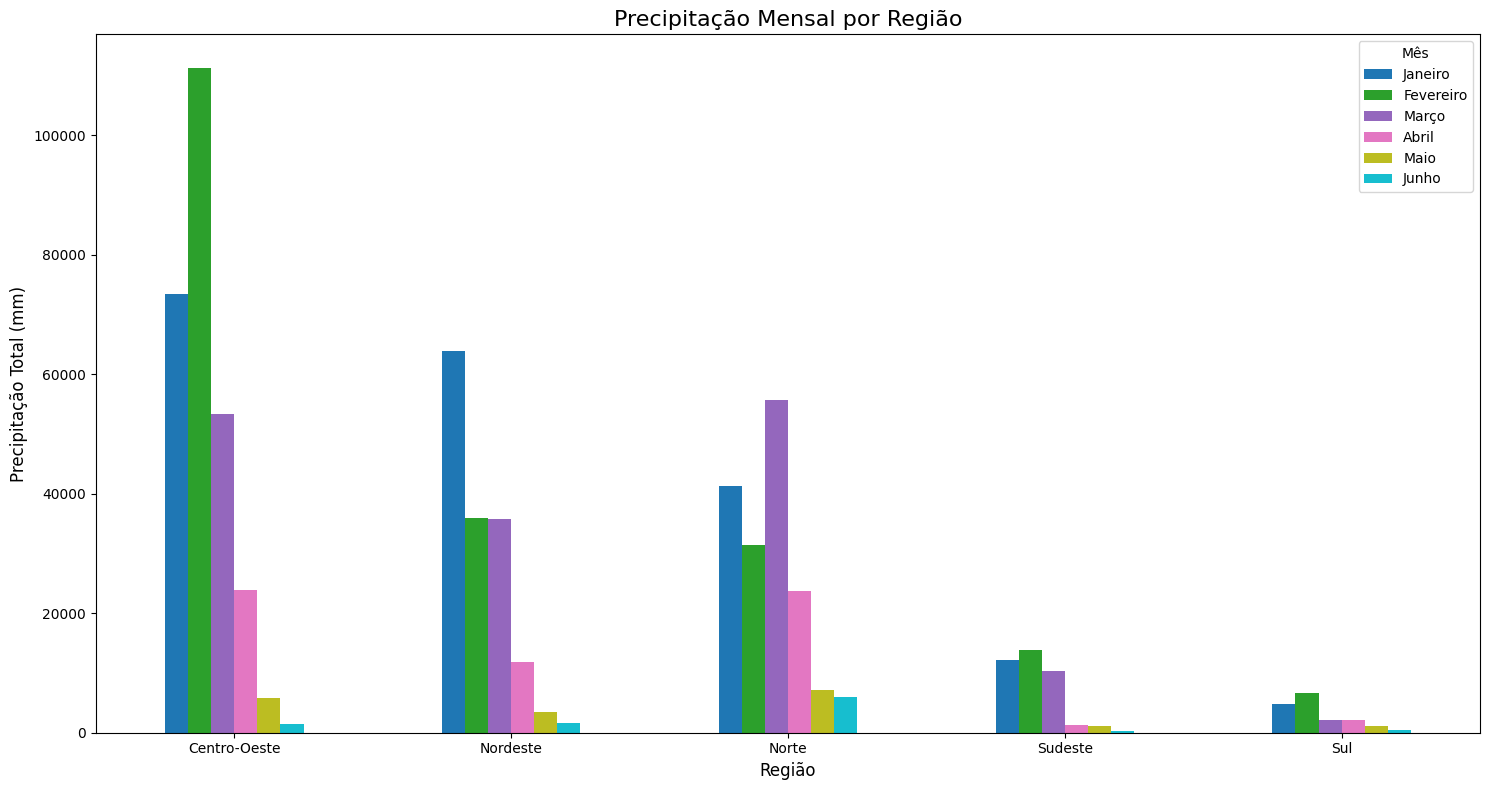

In [71]:
import matplotlib.pyplot as plt

print(df_brasil_2024['mes'].unique())

# Agrupar os dados por 'região' e 'mês' e somar a precipitação
df_agrupado = df_brasil_2024.groupby(['regiao', 'mes'])['precipitacao'].sum().unstack(fill_value=0)

# Verificar o DataFrame agrupado
print(df_agrupado)

# Criar o gráfico de barras para a série temporal (por mês e por região)
plt.figure(figsize=(15, 8))
df_agrupado.plot(kind='bar', stacked=False, figsize=(15, 8), cmap='tab10')

# Configurar título e rótulos
plt.title('Precipitação Mensal por Região', fontsize=16)
plt.xlabel('Região', fontsize=12)
plt.ylabel('Precipitação Total (mm)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Mês', labels=['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho'])

plt.tight_layout()
plt.show()


### 3.6.1 Número de queimadas por região Versus Precipitação (Impacto):

Mostra claramente quais regiões sofreram com maiores volumes de precipitação e mais ocorrências de queimadas no período de janeiro a junho. A soma destaca o efeito cumulativo desses fenômenos, o que é crucial para entender o impacto geral na região.

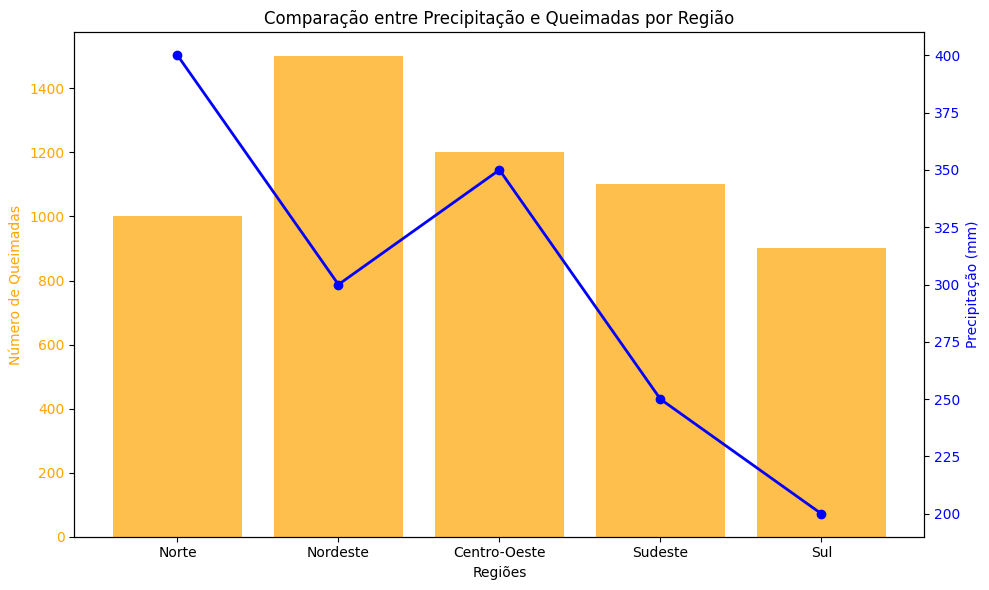

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Dados fictícios para precipitação e queimadas por região
regioes = ['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul']
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago']

# Índices de precipitação (preciso entender sobre esses valores nos dados, nao está coerente para mim, olhando especificamente para o RS)
precipitacao = [400, 300, 350, 250, 200]

# Dados das queimadas (preciso de ajuda para entender como puxar esses valores reais)
queimadas = [1000, 1500, 1200, 1100, 900]

# Gráfico combinado
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de barras - Queimadas
ax1.bar(regioes, queimadas, color='orange', alpha=0.7, label='Queimadas')
ax1.set_xlabel('Regiões')
ax1.set_ylabel('Número de Queimadas', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Eixo secundário para a linha de precipitação
ax2 = ax1.twinx()
ax2.plot(regioes, precipitacao, color='blue', marker='o', linewidth=2, label='Precipitação')
ax2.set_ylabel('Precipitação (mm)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Títulos e layout
plt.title('Comparação entre Precipitação e Queimadas por Região')
fig.tight_layout()

# Mostrar gráfico
plt.show()

### 3.7. Gráfico de Barras Comparativo

In [19]:
#Diana

### 3.8. Histogramas

In [20]:
#Thiago

### 3.9. Gráficos de Satélites

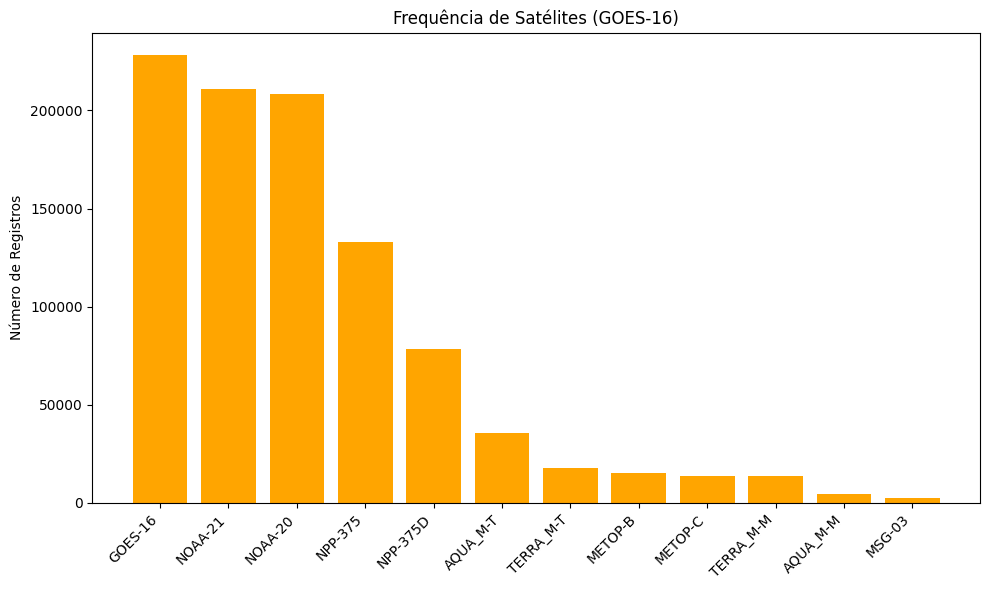

In [80]:
import matplotlib.pyplot as plt

# Contar a frequência do satélite
satelite_counts = df_brasil_2024['satelite'].value_counts()

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(satelite_counts.index, satelite_counts.values, color='orange')
plt.title('Frequência de Satélites (GOES-16)')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

A presença de outros satélites além do GOES-16, como NOAA e NPP, acontece porque o dataset inclui observações feitas por múltiplos satélites que monitoram queimadas e clima. Esses satélites diferentes são utilizados por agências meteorológicas para coletar dados de diversas áreas e complementar as observações.

Por exemplo, o GOES-16 é um satélite geoestacionário específico, enquanto os satélites NOAA e NPP têm órbitas diferentes e contribuem com dados adicionais. Mas nao sei se essa informaçao acrescenta algum valor na análise.